<a href="https://colab.research.google.com/github/adamzki99/nlp-zlatan/blob/feature%2Fall-MiniLM-L6-v2-implementation/nlp_zlatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia

/content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia


# all-MiniLM-L6-v2

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 

In [3]:
import json

with open('valid_random_split.json', 'r') as file:
    json_data = file.read()
    data = json.loads(json_data)

print('Datatype:', type(data))

Datatype: <class 'list'>


In [4]:
import pandas as pd

data_extract = {
    "chosen_topic": [],
    "speaker_passage": [],
    "candidate_responses": []
}

for i, conversation in enumerate(data):

  for j, dialog in enumerate(conversation['dialog']):

    if "Apprentice" in dialog['speaker']:

      data_extract['chosen_topic'].append(conversation['chosen_topic'])
      data_extract['speaker_passage'].append(dialog['text'])
      data_extract['candidate_responses'].append(dialog['candidate_responses'][:20])

extact_df = pd.DataFrame(data_extract)

extact_df

,chosen_topic,speaker_passage,candidate_responses
0,Gardening,"I like Gardening, even when I've only been doi...","[No, I have two rescue cats. The French Bulldo..."
1,Gardening,That sounds great. I've always thought that I...,"[The meaning of the phrase ""ice cream"" varies ..."
2,Gardening,"Great, I love the idea of growing my own veget...",[Isn't that the truth!! have you ever tried an...
3,Gardening,"Wow, it sounds amazing, the Micro-pigs are so ...",[I like them and think they are a cool additio...
4,Gardening,"Great, I enjoyed our chat. Great luck with th...",[Definitely hire someone. I can write but defi...
...,...,...,...
4460,Guitar,The Master of Puppets is a must listen to if y...,[When non-humans have multiple births the grou...
4461,Divorce,That has got to be tough. My parents are still...,"[You can watch a Dalas Mavericks game!, Are th..."
4462,Divorce,I have heard that a divorce can take a while. ...,[I thin my dads is carbonfiber I guess now the...
4463,Divorce,Yea I forget about that when I think about div...,[Yes I've heard about them. When did they buil...


In [6]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00


In [7]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In [8]:
selected_sentences = []
selected_conversation_topics = []

for c, row in extact_df.sample(100).iterrows():
  
  selected_conversation_topics.append(row['chosen_topic'])

  for resp in row['candidate_responses']:
    pair = (row['speaker_passage'], resp)
    selected_sentences.append(pair)

#selected_sentences[::1]

In order for testing the implementation later, we create a copy of the data that was used for training.

In [9]:
implementation_testing_sentences = selected_sentences

Back to training the model...

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# Move model to GPU
model.to(device)

cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

## Using mean-pooling

We are using mean-pooling to aggregate the sentence embeddings into a vector representation that aims to capture the meaning of the sentence. This is performed by averaging the embeddings dimensions.

By also applying the attention mask wich is provided with the model, we are able improve the **accuracy** of the averaging. This is becase the function wont be taking into acount the words that wont provide usefull information, e.g. stop-words.

In [11]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [12]:
def perform_embedding(documents:list, device, model):

  encoded_documents = tokenizer(documents, padding=True, truncation=True, return_tensors='pt')

  encoded_documents.to(device)
  with torch.no_grad():
      model_output_documents = model(**encoded_documents)

  # Perform pooling
  embedding = mean_pooling(model_output_documents, encoded_documents['attention_mask'])

  # Normalize embedding
  #embedding = F.normalize(model_output_message, p=2, dim=1)

  return embedding

In [13]:
sentence_embeddings = perform_embedding(documents = selected_sentences, device = device, model = model)

## Visualizing Cluster with Hypertools

In [14]:
%pip install hypertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=4123ba30531313fa9e6bcfcd33e762e008af2163d97b10150f5bebd4c865474e
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=cd22f4e0c3f4c873906bf866bfbcb97662909df3bfd9f4161a687473883bb82e
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


Number of clusters: 85


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hypertools/plot/plot.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwargs[kwarg]=np.array(kwargs[kwarg])


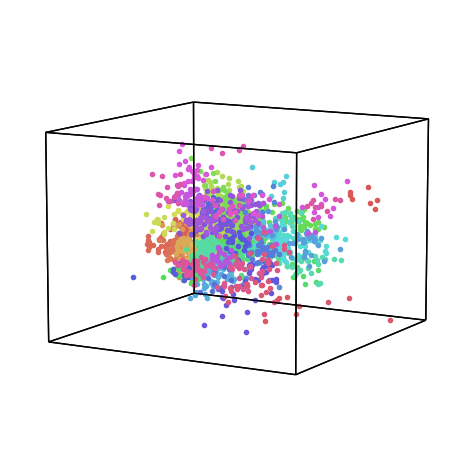

In [15]:
import hypertools as hyp

n_clusters = len(set(selected_conversation_topics))

print("Number of clusters:", n_clusters)

hyp.plot(sentence_embeddings.cpu().detach().numpy(), '.', n_clusters = n_clusters)

## Model usage

In [16]:
%pip install hnswlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.7.0-cp310-cp310-linux_x86_64.whl size=2119837 sha256=ec40a5bf76da2298fde44d2ad54f2a201a12ad31b86dc6c1d6c3973306021b08
  Stored in directory: /root/.cache/pip/wheels/8a/ae/ec/235a682e0041fbaeee389843670581ec6c66872db856dfa9a4
Successfully built hnswlib


In [17]:
import hnswlib

# Create the HNSW index
index = hnswlib.Index(space='l2', dim=sentence_embeddings.shape[1])
index.init_index(max_elements=len(sentence_embeddings), ef_construction=200, M=16)

# Add sentence embeddings to the index
index.add_items(sentence_embeddings.cpu().numpy())

In [18]:
# Get message
random_message = list(extact_df.sample(1).to_dict()['speaker_passage'].values())[0]
message = [random_message]

message

["Oh yeah that's right. Yeah what else has Brandon Sanderson wrote?"]

In [36]:
# Perform a similarity search
def search_embeddings(query:str, k, device, model):

  query_embedding = perform_embedding(documents=query, device=device, model=model)

  indexes, distances = index.knn_query(query_embedding.cpu(), k=k)

  return indexes[0], distances, query_embedding

In [37]:

indexes, distances, query_embedding = search_embeddings(query=message, k=10, device=device, model=model)

k = 10  # Number of closest neighbors to retrieve

print(indexes)

[1995  976   38   11 1330 1602  672  973  145  702]


In [38]:
query_subset = []

for i, ind in enumerate(indexes):
  print("Distance:", distances[0][i], "\t", selected_sentences[ind][1])
  query_subset.append(selected_sentences[ind])

Distance: 15.774924 	 He was, Wilder and Brooks wrote the screenplay too.
Distance: 16.476383 	 That's too bad. It was created by Richard Garfield and published in 1993.
Distance: 17.381334 	 He was, Wilder and Brooks wrote the screenplay too.
Distance: 17.97739 	 Right. I bet his performances are super cool. I think I might have heard "justified".
Distance: 18.068588 	 You may also want to check out the films "Taxi" or "Fever Pitch" as he starred in both.
Distance: 18.473557 	 Ahh.. So that makes sense. Man, sounds like it had a lot of issues getting it made. So, what kind of success or accolades did it receive? Or who directed it?
Distance: 18.5156 	 I never knew about his books. I'll have to check that out.
Distance: 18.574493 	 I don't think I've read that one as our library leaves a bit to be desired in this area.
Distance: 18.727999 	 His books includes, The Early Asimov" (1972), "Before the Golden Age" (1974), and "Buy Jupiter and Other Stories" (1975)
Distance: 18.95446 	 Hosti

## Looking at the result

In [39]:
selected_sentences_embedding = perform_embedding(documents=query_subset, device=device, model=model)

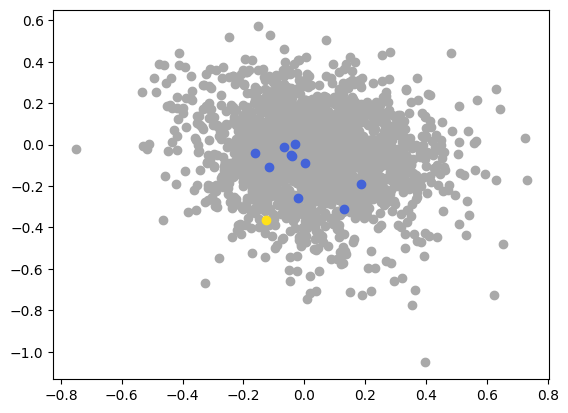

In [40]:
import matplotlib.pyplot as plt

plt.scatter(sentence_embeddings.cpu()[:,0] , sentence_embeddings.cpu()[:,1], c = '#a9a9a9')
plt.scatter(selected_sentences_embedding.cpu()[:,0] , selected_sentences_embedding.cpu()[:,1], c = '#4363d8')
plt.scatter(query_embedding.cpu()[:,0] , query_embedding.cpu()[:,1], color = '#ffe119')
plt.show()

## Testing the model

As we want the model to act as a vector-database we expect it to find the correct passage with the input that was used during training.

In [48]:
score = 0

for _, sentence_pair in enumerate(implementation_testing_sentences):

  indexes, distances, query_embedding = search_embeddings(query=sentence_pair[0], k=5, device=device, model=model)

  results = []
  for _, i in enumerate(indexes):
    results.append(selected_sentences[i])
  

  if sentence_pair in results:
    score += 1
  
print("Accuracy:", score/len(implementation_testing_sentences)*100, "%")

Accuracy: 24.2 %
